# Session 2 Chamodi : Gait Analysis
### Time : 2025-05-31 21:44:45.469000 to 2025-05-31 21:45:25.529000
### Sensor ID : 601
### Steps : 30

## Fetching Raw Data from DynamoDB

In [40]:
import sys
import os
from datetime import datetime

# Append app to sys.path to access modules like app.utils.dynamo
sys.path.append(os.path.abspath("../app"))

In [41]:
from utils.dynamo import fetch_session_data

In [42]:
sensor_id = 601
start_time = datetime.fromisoformat("2025-05-31 23:09:16.722000")
end_time = datetime.fromisoformat("2025-05-31 23:09:40.685000")

data = fetch_session_data(sensor_id, start_time, end_time)
print(f"📦 Retrieved {len(data)} records")



🔍 [DEBUG] Fetching data for Sensor ID: 601
🕒 [DEBUG] Start Time: 2025-05-31 23:09:16.722000 -> 1748713156722
🕒 [DEBUG] End Time:   2025-05-31 23:09:40.685000 -> 1748713180685
📦 [DEBUG] Retrieved 238 items from DynamoDB.

📦 Retrieved 238 records


In [43]:
data

[{'gyro_cal': Decimal('3'),
  'mag_cal': Decimal('3'),
  'roll': Decimal('-99'),
  'type': 'sensor_data',
  'FSR_12': Decimal('1792'),
  'FSR_11': Decimal('0'),
  'FSR_10': Decimal('1162'),
  'FSR_16': Decimal('1438'),
  'FSR_15': Decimal('746'),
  'FSR_1': Decimal('0'),
  'FSR_14': Decimal('4095'),
  'FSR_13': Decimal('2313'),
  'FSR_3': Decimal('3342'),
  'FSR_2': Decimal('0'),
  'FSR_5': Decimal('814'),
  'FSR_4': Decimal('3247'),
  'pitch': Decimal('5.56'),
  'FSR_7': Decimal('0'),
  'FSR_6': Decimal('2485'),
  'FSR_9': Decimal('2395'),
  'timestamp': Decimal('1748713156723'),
  'FSR_8': Decimal('0'),
  'q0': Decimal('0.66'),
  'q1': Decimal('0.69'),
  'q2': Decimal('0.2'),
  'q3': Decimal('0.22'),
  'device_id': '601',
  'yaw': Decimal('-26.12'),
  'gx': Decimal('-5.31'),
  'gy': Decimal('-3.44'),
  'gz': Decimal('-12.44'),
  'sys_cal': Decimal('3'),
  'accel_cal': Decimal('3'),
  'ax': Decimal('0.4'),
  'ay': Decimal('0.06'),
  'az': Decimal('-0.17')},
 {'gyro_cal': Decimal('3'),

## Step 1 :  Preprocess and Sort

### Sort By Timestamp

In [44]:
import pandas as pd
from decimal import Decimal

# Convert to DataFrame
df = pd.json_normalize(data)

# Convert all Decimal values to float (optional but useful)
df = df.map(lambda x: float(x) if isinstance(x, Decimal) else x)

# Sort by timestamp
df = df.sort_values(by="timestamp").reset_index(drop=True)

# Show first few rows
df.head()


,gyro_cal,mag_cal,roll,type,FSR_12,FSR_11,FSR_10,FSR_16,FSR_15,FSR_1,...,device_id,yaw,gx,gy,gz,sys_cal,accel_cal,ax,ay,az
0,3.0,3.0,-99.00,sensor_data,1792.0,0.0,1162.0,1438.0,746.0,0.0,...,601,-26.12,-5.31,-3.44,-12.44,3.0,3.0,0.40,0.06,-0.17
1,3.0,3.0,-98.25,sensor_data,1269.0,0.0,0.0,783.0,17.0,0.0,...,601,-25.06,-7.00,-11.94,1.25,3.0,3.0,0.17,-0.02,0.09
2,3.0,3.0,-97.37,sensor_data,0.0,0.0,0.0,0.0,68.0,0.0,...,601,-25.12,-8.94,-4.37,7.56,3.0,3.0,-0.05,0.21,0.19
3,3.0,3.0,-96.25,sensor_data,0.0,0.0,0.0,0.0,39.0,0.0,...,601,-24.50,-12.19,-9.44,-2.75,3.0,3.0,0.42,0.28,0.18
4,3.0,3.0,-94.94,sensor_data,0.0,0.0,0.0,0.0,77.0,0.0,...,601,-22.44,-10.50,-5.19,-14.87,3.0,3.0,0.15,-0.21,0.36


### Check for Missing FSR Values

In [45]:
required_fsrs = [f"FSR_{i}" for i in range(1, 17)]
missing = [col for col in required_fsrs if col not in df.columns]
print("Missing FSR columns:", missing)

Missing FSR columns: []


### Clipping FSR values (0 to 4095)

In [46]:
for col in required_fsrs:
    df[col] = df[col].clip(0, 4095)


### Normalizing  Timestamps 

In [47]:
df["time_sec"] = df["timestamp"] - df["timestamp"].min()

### Foot Region to Sensor Mapping

| Region Name  | Sensors Included                                                  | Function in Gait Cycle       |
| ------------ | ----------------------------------------------------------------- | ---------------------------- |
| **Forefoot** | FSR\_5, FSR\_6, FSR\_7, FSR\_8, FSR\_9, FSR\_12, FSR\_15, FSR\_16 | Toe-off, Push-off            |
| **Midfoot**  | FSR\_1, FSR\_2, FSR\_10, FSR\_11, FSR\_13, FSR\_14                | Load-bearing, Mid-stance     |
| **Rearfoot** | FSR\_3, FSR\_4                                                    | Heel strike, Initial contact |


In [50]:
REGION_MAP = {
    "forefoot": [5, 6, 7, 8, 9, 12, 15, 16],
    "midfoot": [1, 2, 10, 11, 13],
    "rearfoot": [3, 4]
}


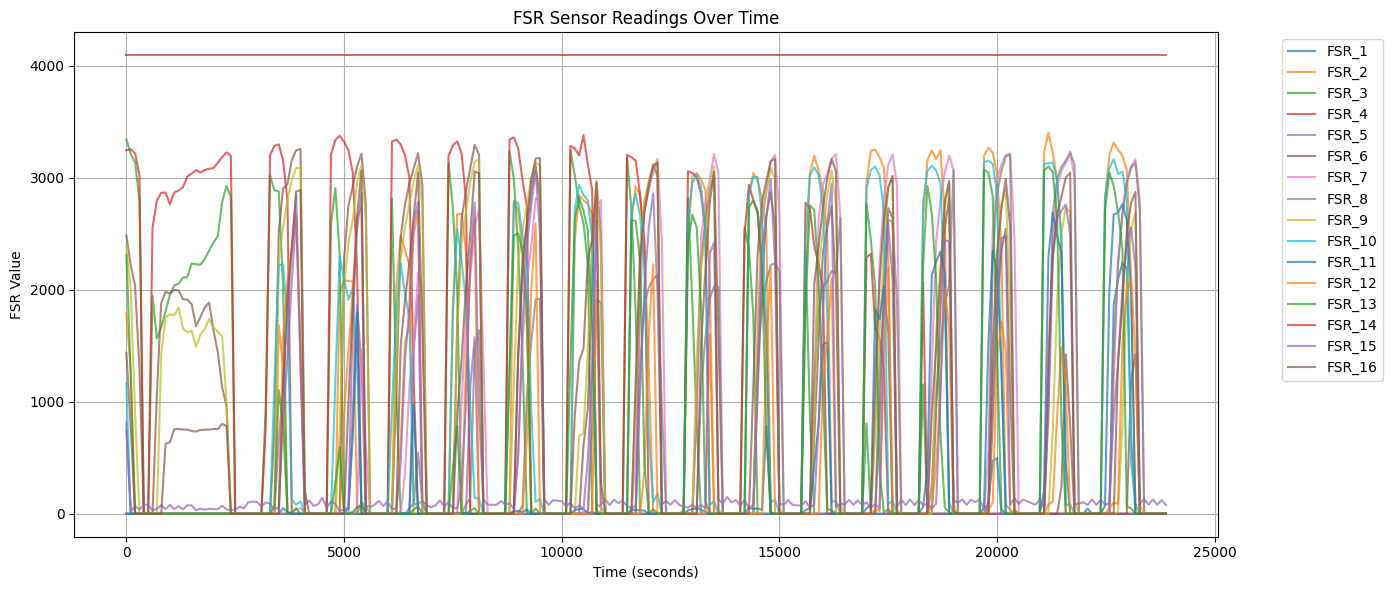

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for i in range(1, 17):
    plt.plot(df["time_sec"], df[f"FSR_{i}"], label=f"FSR_{i}", alpha=0.7)

plt.xlabel("Time (seconds)")
plt.ylabel("FSR Value")
plt.title("FSR Sensor Readings Over Time")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=1)
plt.tight_layout()
plt.grid(True)
plt.show()
